In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizar información general

In [151]:
org_data_path = "../CHESS/data/chess_games.csv"
chess_data = pd.read_csv(org_data_path)

# Tratamiento de valores faltantes

In [153]:
chess_data.isnull().sum()

game_id                  0
rated                    0
turns                    0
victory_status           0
winner                   0
time_increment           0
white_id                 0
white_rating             0
black_id                 0
black_rating             0
moves                    0
opening_code             0
opening_moves            0
opening_fullname         0
opening_shortname        0
opening_response     18851
opening_variation     5660
dtype: int64

Se calcula el procentaje de valores faltantes en la columna opening response

In [129]:
total_entries = 20058
missing_opening_response = 18851

percentage_missing = (missing_opening_response / total_entries) * 100
percentage_missing

93.982450892412

Con estos resultados y sabiendo que no será muy relevante para el modelo, se concluye en la eliminación de la columna opening_response.

In [130]:
df_1 = chess_data.drop(['opening_response'], axis=1)

Respecto a la columna opening_variation, representa las variantes de las aperturas más tradicionales. Si no existe nombre para una variante, es porque esa fila representa la apertura en su variante 'tradicional', por tanto, se rellenan los valores faltantes con esta oración:

In [131]:
#rellenando la columna Opening_variation los blanks con "traditional opening"
df_1['opening_variation'] = chess_data['opening_variation'].fillna('traditional opening')
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   game_id            20058 non-null  int64 
 1   rated              20058 non-null  bool  
 2   turns              20058 non-null  int64 
 3   victory_status     20058 non-null  object
 4   winner             20058 non-null  object
 5   time_increment     20058 non-null  object
 6   white_id           20058 non-null  object
 7   white_rating       20058 non-null  int64 
 8   black_id           20058 non-null  object
 9   black_rating       20058 non-null  int64 
 10  moves              20058 non-null  object
 11  opening_code       20058 non-null  object
 12  opening_moves      20058 non-null  int64 
 13  opening_fullname   20058 non-null  object
 14  opening_shortname  20058 non-null  object
 15  opening_variation  20058 non-null  object
dtypes: bool(1), int64(5), object(10)
memory 

Ya no hay columnas con valores faltantes. Entonces procedemos a describir las columnas numéricas del df:

In [132]:
chess_data.describe()

,game_id,turns,white_rating,black_rating,opening_moves
count,20058.000000,20058.000000,20058.000000,20058.000000,20058.000000
mean,10029.500000,60.465999,1596.631868,1588.831987,4.816981
std,5790.390185,33.570585,291.253376,291.036126,2.797152
min,1.000000,1.000000,784.000000,789.000000,1.000000
25%,5015.250000,37.000000,1398.000000,1391.000000,3.000000
50%,10029.500000,55.000000,1567.000000,1562.000000,4.000000
75%,15043.750000,79.000000,1793.000000,1784.000000,6.000000
max,20058.000000,349.000000,2700.000000,2723.000000,28.000000


Ahora que se tiene un dataframe sin valores faltantes. Es posible proceder con los siguientes analisis: 
- Distribución de las variables numéricas
- Exploración de las variables categóricas
- Relación entre variables

Para dividir las calificaciones de los jugadores en las categorías de "Beginner", "Intermediate", "Advanced", y "Master" se determinará mediante cuartiles.

Primero, se determinan los valores de estos cuartiles para las calificaciones de los jugadores de blanco y negro.

Luego, se crea una función que asigna cada calificación a una de estas categorías según los cuartiles calculados.

In [133]:
import numpy as np
from scipy import stats
combined_ratings = pd.concat([chess_data['white_rating'], chess_data['black_rating']])
combined_ratings
print("Promedio de elos: %.3f" % np.mean(combined_ratings))
print("Mediana de Elos: %.3f" % np.median(combined_ratings))
print("Desviación estandar de elos: %.3f" % np.std(combined_ratings))
overall_quartiles = combined_ratings.quantile([0.25, 0.5, 0.75]).values
print("95%c de los datos entre %.3f y %.3f" % ('%', overall_quartiles[0], overall_quartiles[2]))
print("Skew de la distribución: %.3f" % (stats.skew(combined_ratings))) 

Promedio de elos: 1592.732
Mediana de Elos: 1564.000
Desviación estandar de elos: 291.164
95% de los datos entre 1394.000 y 1788.000
Skew de la distribución: 0.280


In [134]:
overall_quartiles

array([1394., 1564., 1788.])

Por tanto:
- Percentil 25%: 1394
- Percentil 50%: 1564
- Percentil 75%: 1788

Clasificaciones:
- Begginer: Abajo de percentil 25%
- Intermediate: Entre 25% y 50%
- Advanced: Entre 50% y 75%
- Master: Arriba de 75%

In [135]:
def categorize_rating(rating, overall_quartiles):
    if rating <= overall_quartiles[0]:
        return 'Beginner'
    elif rating <= overall_quartiles[1]:
        return 'Intermediate'
    elif rating <= overall_quartiles[2]:
        return 'Advanced'
    else:
        return 'Master'

In [136]:
chess_data['white_category'] = chess_data['white_rating'].apply(lambda x: categorize_rating(x, overall_quartiles))
chess_data['black_category'] = chess_data['black_rating'].apply(lambda x: categorize_rating(x, overall_quartiles))

## Identificar variables categóricas

In [148]:
cat_vars = chess_data.select_dtypes(include=['object']).columns
num_vars = chess_data._get_numeric_data().columns
print(f"Columnas categóricas: {cat_vars}")
print(f"Columnas numéricas: {num_vars}")

Columnas categóricas: Index(['victory_status', 'winner', 'time_increment', 'white_id', 'black_id',
       'moves', 'opening_code', 'opening_fullname', 'opening_shortname',
       'opening_response', 'opening_variation', 'white_category',
       'black_category'],
      dtype='object')
Columnas numéricas: Index(['game_id', 'rated', 'turns', 'white_rating', 'black_rating',
       'opening_moves'],
      dtype='object')


### Graficar en general las columnas categóricas

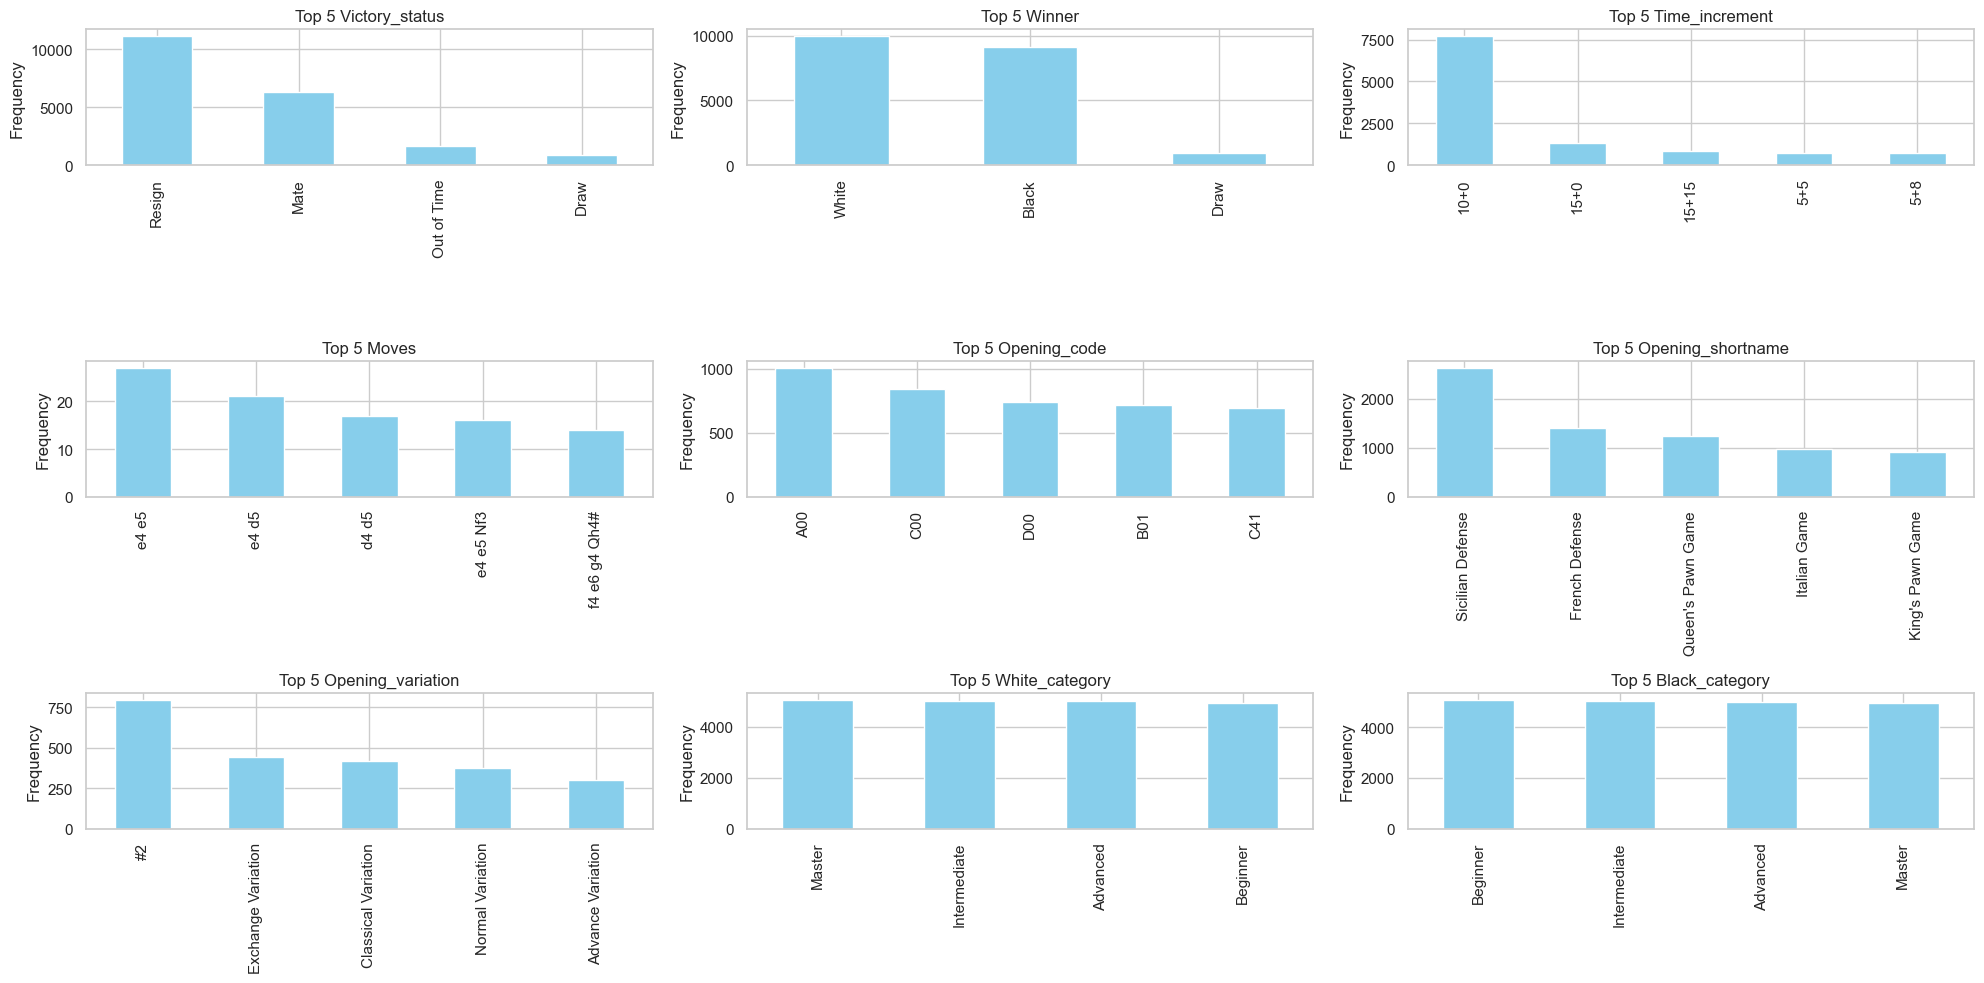

In [149]:
categorical_columns = ['victory_status', 'winner', 'time_increment',
       'moves', 'opening_code', 'opening_shortname', 'opening_variation', 'white_category',
       'black_category']

def plot_top_categories(data, column, ax, title):
    top_categories = data[column].value_counts().head(5)
    top_categories.plot(kind='bar', ax=ax, color='skyblue')
    ax.set_title(title)
    # ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))
fig.tight_layout(pad=5.0)

for ax, column in zip(axes.flatten(), categorical_columns):
    if column in chess_data:
        plot_top_categories(chess_data, column, ax, f'Top 5 {column.capitalize()}')

# Ajustar la figura para mostrar todos los gráficos claramente
plt.tight_layout()
plt.show()

# Distribución de variables numéricas

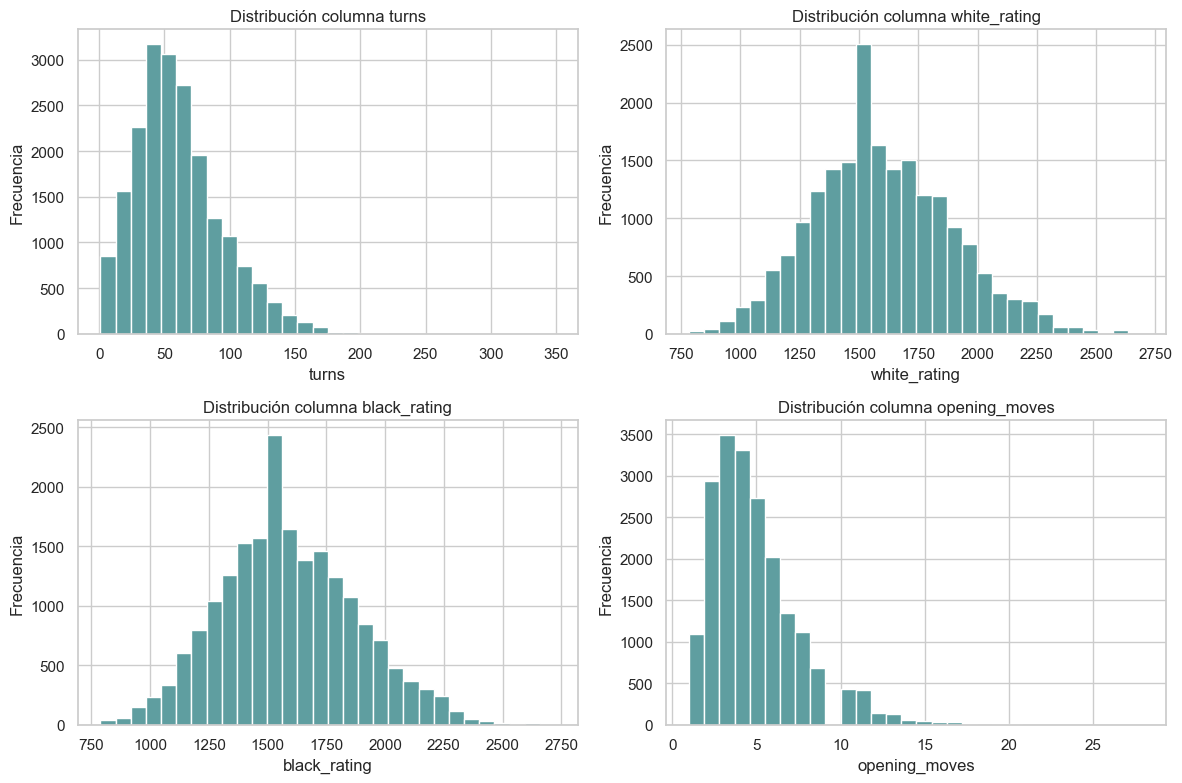

In [150]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.tight_layout(pad=5.0)

# Lista de columnas numéricas a graficar, excluyendo 'game_id'
numeric_columns = ['turns', 'white_rating', 'black_rating', 'opening_moves']

# Graficar histogramas para cada columna numérica
for ax, column in zip(axes.flatten(), numeric_columns):
    chess_data[column].hist(bins=30, ax=ax, color='cadetblue')
    ax.set_title(f'Distribución columna {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frecuencia')

# Ajustar la disposición para evitar la superposición de etiquetas
plt.tight_layout()
plt.show()

# Distribución de nivel de jugadores vs Frecuencia de juegos

En el siguiente gráfico es posible observar el elo o ranting de los jugadores en este dataset, siendo 1500 predominante y el rango entre 1394 y 1788 donde se concentran la mayoría de los jugadores. Rango que es más corto que el resto de los niveles. Lo que indica que se necesite un salto de calidad para superar esta puntuación y que hay cierto estancamiento en este rango. 

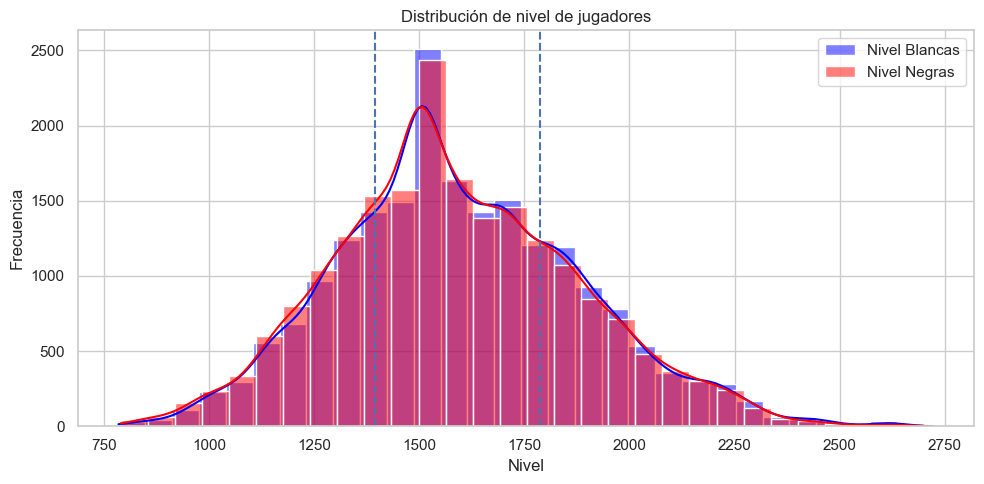

In [137]:
# Distribution of player ratings
plt.figure(figsize=(10, 5))
sns.histplot(chess_data['white_rating'], color='blue', bins=30, kde=True, label='Nivel Blancas')
sns.histplot(chess_data['black_rating'], color='red', bins=30, kde=True, label='Nivel Negras')
plt.axvline(x=overall_quartiles[0], linestyle='--', markersize=12)
plt.axvline(x=overall_quartiles[2], linestyle='--', markersize=12)
plt.title('Distribución de nivel de jugadores')
plt.xlabel('Nivel')
plt.ylabel('Frecuencia')
plt.legend()

plt.tight_layout()
plt.show()

### Aperturas más comunes según nivel y su frecuencia de juego

Volviendo categórica white_rating y black_rating

Para sustentar la teoría de que los jugadores que llegan a cierto elo necesitan aprender aperturas para dar un salto de calidad y subir de nivel, hay que explorar la frecuencia en la que se juegan las aperturas más comunes en este dataset según el rating de los jugadores.

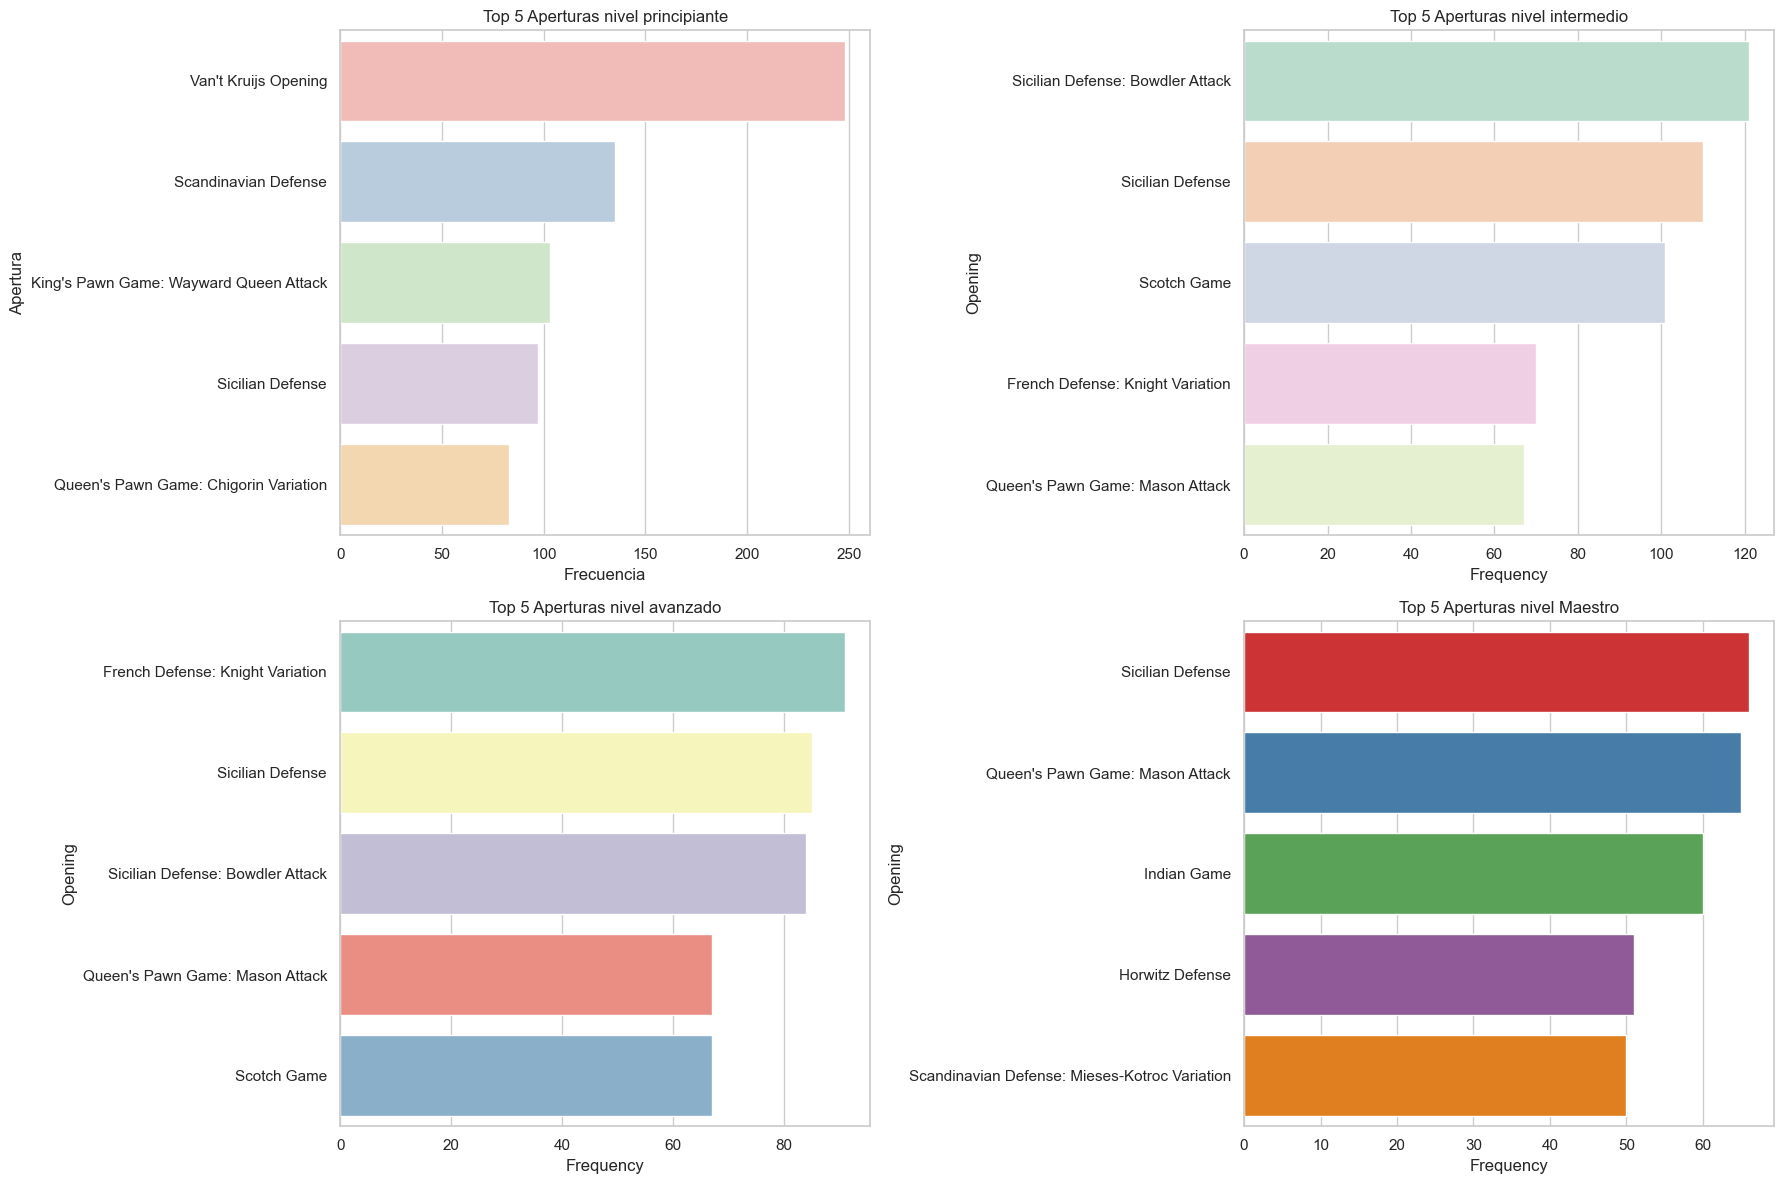

In [138]:
# Filter data for each category
beginner_openings = chess_data[chess_data['white_category'] == 'Beginner']['opening_fullname'].value_counts().head(5)
intermediate_openings = chess_data[chess_data['white_category'] == 'Intermediate']['opening_fullname'].value_counts().head(5)
advanced_openings = chess_data[chess_data['white_category'] == 'Advanced']['opening_fullname'].value_counts().head(5)
master_openings = chess_data[chess_data['white_category'] == 'Master']['opening_fullname'].value_counts().head(5)

# Set up the visualization layout
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

sns.barplot(ax=axes[0, 0], x=beginner_openings.values, y=beginner_openings.index, palette='Pastel1')
axes[0, 0].set_title('Top 5 Aperturas nivel principiante')
axes[0, 0].set_xlabel('Frecuencia')
axes[0, 0].set_ylabel('Apertura')

sns.barplot(ax=axes[0, 1], x=intermediate_openings.values, y=intermediate_openings.index, palette='Pastel2')
axes[0, 1].set_title('Top 5 Aperturas nivel intermedio')
axes[0, 1].set_xlabel('Frequency')
axes[0, 1].set_ylabel('Opening')

sns.barplot(ax=axes[1, 0], x=advanced_openings.values, y=advanced_openings.index, palette='Set3')
axes[1, 0].set_title('Top 5 Aperturas nivel avanzado')
axes[1, 0].set_xlabel('Frequency')
axes[1, 0].set_ylabel('Opening')

sns.barplot(ax=axes[1, 1], x=master_openings.values, y=master_openings.index, palette='Set1')
axes[1, 1].set_title('Top 5 Aperturas nivel Maestro')
axes[1, 1].set_xlabel('Frequency')
axes[1, 1].set_ylabel('Opening')

plt.tight_layout()
plt.show()

Sabiendo que las categorías están perfectamente balanceadas, rápidamente podemos notar que la frecuencia con que las aperturas más populares se juegan va disminuyendo, esto es porque los jugadores avanzados van conociendo y dominando más variedad de aperturas.

Este gráfico da fuerza a la teoría de que para dar un salto de calidad en ajedrez hay que aprender aperturas y entender, como ya se dijo, sus ventajas y desventajas posicionales y tácticas. 

Respecto a nivel principiante, el hecho de que Van't Kruijs Opening sea la apertura más popular no indica que sea buena, para entender el problema habrá que representar esta apertura:

In [139]:
import chess
import chess.svg

beginner_most_common_opening = chess_data[chess_data['white_category'] == 'Beginner']['opening_fullname'].value_counts().idxmax()

example_game_moves = chess_data[chess_data['opening_fullname'] == beginner_most_common_opening]['moves'].iloc[0]
example_game_opening_moves_count = chess_data[chess_data['opening_fullname'] == beginner_most_common_opening]['opening_moves'].iloc[0]

# Split the moves and take only up to the specified opening_moves count
specific_opening_moves = example_game_moves.split()[:example_game_opening_moves_count]
beginner_most_common_opening, specific_opening_moves, example_game_opening_moves_count

("Van't Kruijs Opening", ['e3'], 1)

Con este analisis, se entiende que la apertura más común en realidad es un solo movimiento, porque lo que viene después es caótico y no tiene fundamento en las buenas prácticas del ajedrez. Esto refuerza la teoría que para avanzar en ajedrez, hay que aprender aperturas.

Veamos el tablero que forma esta jugada: 

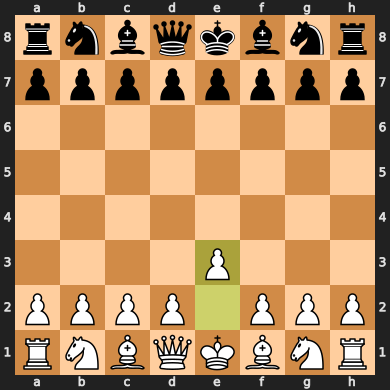

In [140]:
# Create a new chess board
board = chess.Board()

# Apply the Van't Kruijs Opening moves
moves = specific_opening_moves
for move in moves:
    board.push_san(move)

board

Volviendo a revisar la distribución, veamos que tan bien distribuidas está la clase objetivo y el tipo de victoria.

Es posible observar que empate tiene una distribución muy baja. Esto no afecta al modelo porque el objetivo es entender qué movimientos mejoran la posición para ganar con determinado color. No se busca perfeccionar la predicción de empate, se busca mostrar en cada movimiento, qué tanto se acerca el jugador a una posición ganadora. Por tanto, no se realizará ninguna técnica para mejorar el balance de las clases directamente en los datos (Por lo menos hasta este punto del análisis).

Se puede observar que el simple hecho de jugar con blancas lleva implícita cierta ventaja, esto es porque es el primer jugador en mover y tiene el poder de decidir el rumbo del juego, en adelante la tarea de negras es buscar una posición de igualdad de fuerzas. 

La distribución de estatus de victoria muestra que es común que los jugadores en ajedrez reconozcan la ventaja del rival al acercarse el final y concedan la victoria por la vía de la rendición. Esto ayuda al modelo, ya que al extraer características de una posición ganadora y no del mate ya concedido, el modelo puede percibir cosas que son importantes desde antes de que las reglas mismas determinen jaque mate. 

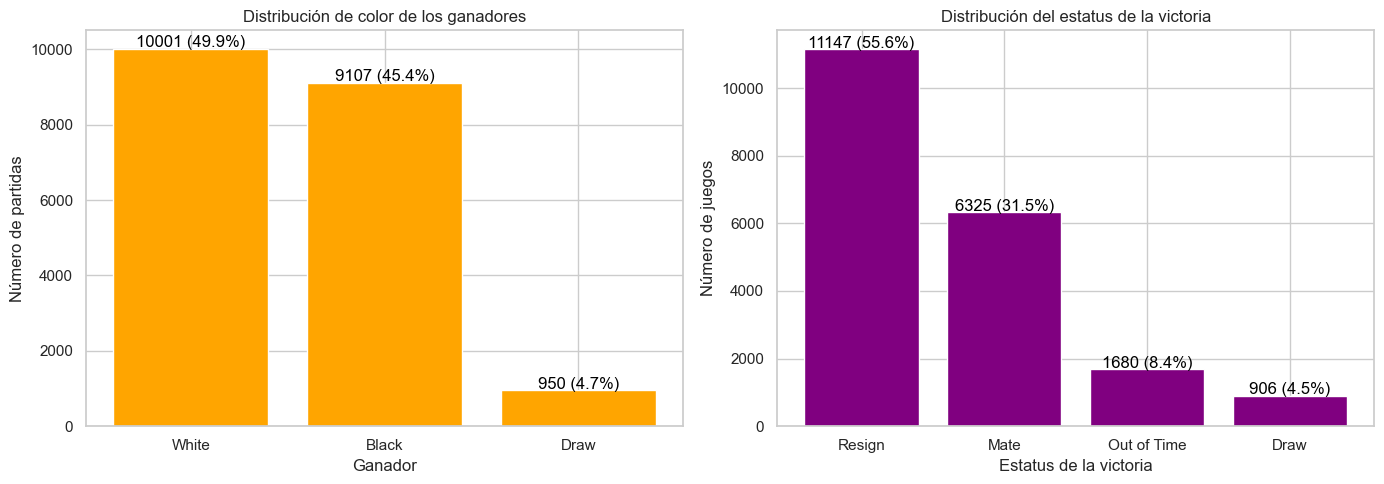

In [141]:
# Setting up visualization style
sns.set_theme(style="whitegrid")

victory_counts = chess_data['victory_status'].value_counts()
winner_counts = chess_data['winner'].value_counts()
victory_percentages = (victory_counts / victory_counts.sum()) * 100
winner_percentages = (winner_counts / winner_counts.sum()) * 100

# Set up the figure and axes for updated bar charts with numbers and percentages
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart for winners with count and percentage labels
ax[0].bar(winner_counts.index, winner_counts.values, color='orange')
ax[0].set_title('Distribución de color de los ganadores')
ax[0].set_xlabel('Ganador')
ax[0].set_ylabel('Número de partidas')
for i, v in enumerate(winner_counts):
    ax[0].text(i, v + 50, f"{v} ({winner_percentages[i]:.1f}%)", color='black', ha='center')

# Bar chart for victory statuses with count and percentage labels
ax[1].bar(victory_counts.index, victory_counts.values, color='purple')
ax[1].set_title('Distribución del estatus de la victoria')
ax[1].set_xlabel('Estatus de la victoria')
ax[1].set_ylabel('Número de juegos')
for i, v in enumerate(victory_counts):
    ax[1].text(i, v + 50, f"{v} ({victory_percentages[i]:.1f}%)", color='black', ha='center')



plt.tight_layout()
plt.show()

Ahora para demostrar que dependiendo el color que le toca a un jugador de alto nivel, se puede decantar por cierta apertura, hay que analizar el porcentaje de victoria de los diferentes tipos de aperturas de maestros. 

In [142]:
master_openings = chess_data[chess_data['white_category'] == 'Master']['opening_fullname'].value_counts().head(10)


# Win rates for these openings
win_rates = chess_data[chess_data['opening_fullname'].isin(master_openings.index)].groupby(['opening_fullname', 'winner']).size().unstack(fill_value=0)
win_rates['total'] = win_rates.sum(axis=1)
win_rates['white_win_rate'] = win_rates['White'] / win_rates['total']
win_rates['black_win_rate'] = win_rates['Black'] / win_rates['total']
win_rates['draw_rate'] = win_rates['Draw'] / win_rates['total']
win_rates

winner,Black,Draw,White,total,white_win_rate,black_win_rate,draw_rate
opening_fullname,,,,,,,
French Defense: Exchange Variation,42,9,58,109,0.532110,0.385321,0.082569
French Defense: Knight Variation,121,15,135,271,0.498155,0.446494,0.055351
Horwitz Defense,94,5,110,209,0.526316,0.449761,0.023923
Indian Game,100,12,69,181,0.381215,0.552486,0.066298
Modern Defense,87,6,81,174,0.465517,0.500000,0.034483
Queen's Pawn Game: Mason Attack,103,13,116,232,0.500000,0.443966,0.056034
Scandinavian Defense: Mieses-Kotroc Variation,89,6,164,259,0.633205,0.343629,0.023166
Sicilian Defense,194,15,149,358,0.416201,0.541899,0.041899
Sicilian Defense: Bowdler Attack,164,13,119,296,0.402027,0.554054,0.043919


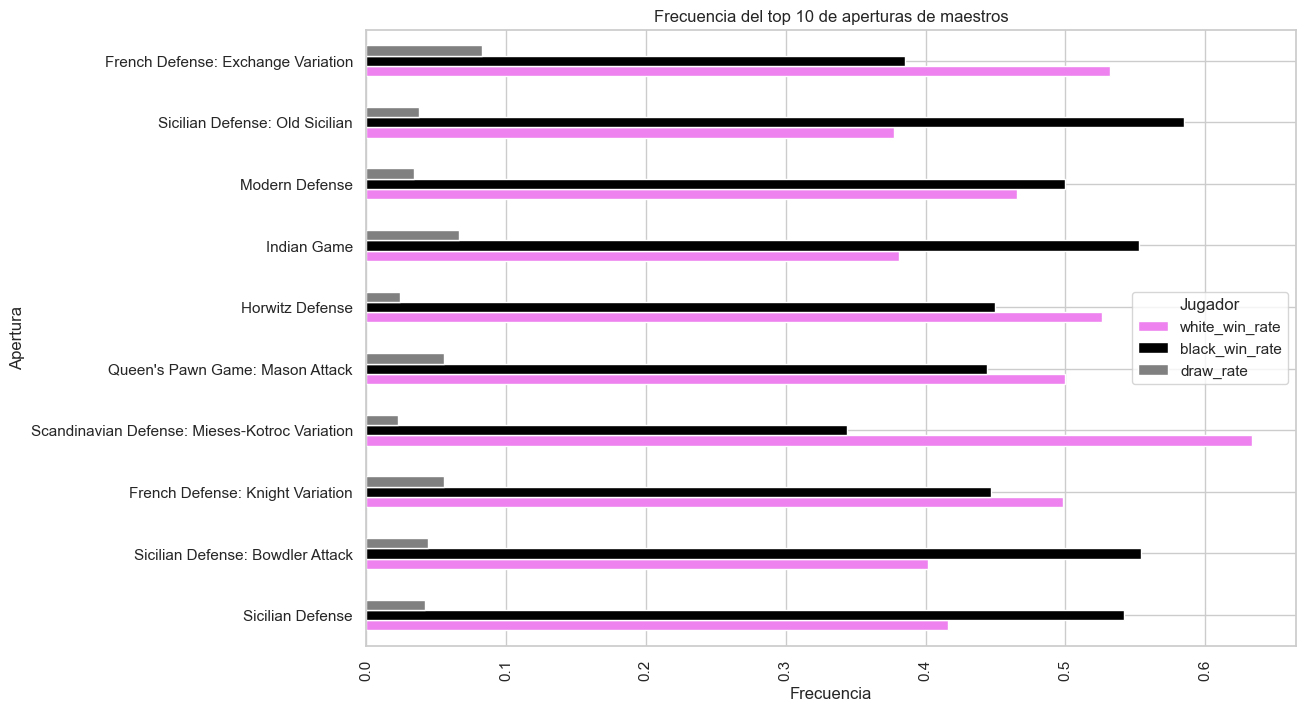

In [143]:
# Sorting by total games to see the most popular openings in terms of games played
win_rates_sorted = win_rates.sort_values(by='total', ascending=False)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
win_rates_sorted[['white_win_rate', 'black_win_rate', 'draw_rate']].plot(kind='barh', ax=ax, color=['violet', 'black', 'gray'])


ax.set_title('Frecuencia del top 10 de aperturas de maestros')
ax.set_xlabel('Frecuencia')
ax.set_ylabel('Apertura')
ax.legend(title='Jugador')
plt.xticks(rotation=90)
plt.show()

Como se observa en el gráfico, es comun que los jugadores de alto nivel busquen jugar defensa siciliana o juego indio cuando juegan con negras y defensa francesa o defensa escandinaba con blancas. Hay que recordar que el que una posición se genere siempre depende de ambos jugadores, por lo que los planes de el oponente se pueden evitar en algunas ocasiones conociendo diferentes variantes de cada apertura. 

In [147]:
chess_data.to_csv("../CHESS/data/df_1.csv", index=False)